# Predicción de Vacunación con CatBoost y BayesSearch

## Introducción

En este notebook, implementaremos un modelo basado en CatBoost para predecir la probabilidad de vacunación contra H1N1 y vacunas estacionales. Usaremos BayesSearch de Scikit-learn para la optimización de hiperparámetros y realizaremos un análisis detallado de las métricas del modelo.

In [7]:
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import joblib
import matplotlib.pyplot as plt
import os

## 1. Carga de datos

Comenzamos cargando los dataset preprocesados tras la división hecha por train_test_split. Contienen las características y las variables objetivo: h1n1_vaccine y seasonal_vaccine.

In [2]:
# Cargar datos
X_train = pd.read_csv("../../Data/preprocessed_X_train.csv", index_col="respondent_id")
X_test = pd.read_csv("../../Data/preprocessed_X_test.csv", index_col="respondent_id")
y_train = pd.read_csv("../../Data/preprocessed_y_train.csv", index_col="respondent_id")
y_test = pd.read_csv("../../Data/preprocessed_y_test.csv", index_col="respondent_id")

## 2. Optimización de Hiperparámetros

Usamos BayesSearch para encontrar los mejores hiperparámetros para nuestro modelo CatBoost.

In [3]:
# Espacio de búsqueda
search_space = {
    'depth': Integer(3, 10),  # Profundidad del árbol
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),  # Tasa de aprendizaje
    'l2_leaf_reg': Real(1, 10, prior='log-uniform'),  # Regularización L2
    'bagging_temperature': Real(0.0, 1.0),  # Temperatura de bagging
    'iterations': Integer(50, 500),  # Número de iteraciones
    'random_strength': Real(0.0, 10.0),  # Fuerza de aleatoriedad
    'auto_class_weights': Categorical(['Balanced', 'SqrtBalanced']),  # Pesos automáticos
}

In [4]:
# Modelo base para H1N1
catboost_h1n1 = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=0,
    random_seed=42
)

# BayesSearchCV para H1N1
opt_h1n1 = BayesSearchCV(
    estimator=catboost_h1n1,
    search_spaces=search_space,
    cv=5,
    n_iter=50,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
)

# Entrenar el modelo para H1N1
opt_h1n1.fit(X_train, y_train['h1n1_vaccine'])

# Mostrar los mejores hiperparámetros para H1N1
print("Mejores hiperparámetros para H1N1:", opt_h1n1.best_params_)
print("Mejor puntaje (AUROC):", opt_h1n1.best_score_)

Mejores hiperparámetros para H1N1: OrderedDict({'auto_class_weights': 'SqrtBalanced', 'bagging_temperature': 1.0, 'depth': 5, 'iterations': 404, 'l2_leaf_reg': 10.0, 'learning_rate': 0.0428709991527715, 'random_strength': 0.0})
Mejor puntaje (AUROC): 0.8674842517035095


In [5]:
# Modelo base para vacuna estacional
catboost_seasonal = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=0,
    random_seed=42
)

# BayesSearchCV para vacuna estacional
opt_seasonal = BayesSearchCV(
    estimator=catboost_seasonal,
    search_spaces=search_space,
    cv=5,
    n_iter=50,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
)

# Entrenar el modelo para vacuna estacional
opt_seasonal.fit(X_train, y_train['seasonal_vaccine'])

# Mostrar los mejores hiperparámetros para vacuna estacional
print("Mejores hiperparámetros para vacuna estacional:", opt_seasonal.best_params_)
print("Mejor puntaje (AUROC):", opt_seasonal.best_score_)

Mejores hiperparámetros para vacuna estacional: OrderedDict({'auto_class_weights': 'Balanced', 'bagging_temperature': 1.0, 'depth': 8, 'iterations': 500, 'l2_leaf_reg': 10.0, 'learning_rate': 0.020287964540729175, 'random_strength': 0.0})
Mejor puntaje (AUROC): 0.863904730921916


## 3. Evaluación del Modelo

**Métricas de Rendimiento:**

- ROC AUC: Calculamos el área bajo la curva ROC.
- Curva ROC: Representación gráfica de los valores de TPR y FPR.
- Matriz de Confusión: Analizamos el desempeño del modelo en clases.
- Accuracy: Proporción de predicciones correctas realizadas por el modelo en comparación con el total de predicciones.

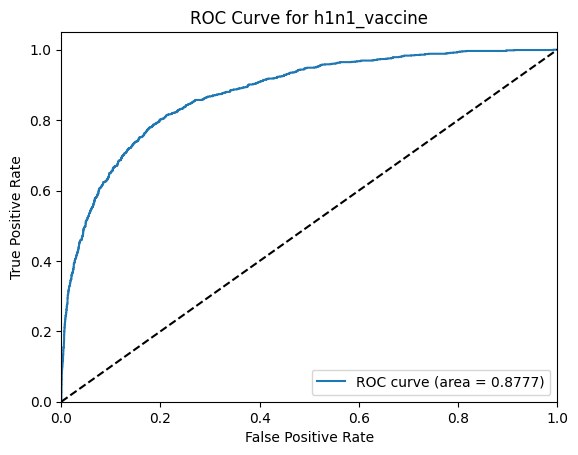

AUROC para H1N1: 0.8777257120239083


In [8]:
model_h1n1 = opt_h1n1.best_estimator_
model_seasonal = opt_seasonal.best_estimator_

# Predicción y evaluación para H1N1
h1n1_predictions = model_h1n1.predict(X_test)
h1n1_probabilities = model_h1n1.predict_proba(X_test)[:, 1]

# Calculamos la curva ROC y el valor ROC AUC para h1n1_vaccine
fpr, tpr, thresholds = roc_curve(y_test['h1n1_vaccine'], h1n1_probabilities)
roc_auc_h1n1 = roc_auc_score(y_test['h1n1_vaccine'], h1n1_probabilities)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc_h1n1)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for h1n1_vaccine')
plt.legend(loc="lower right")
plt.show()
print(f"AUROC para H1N1: {roc_auc_h1n1}")

In [9]:
# Predicciones binarias para calcular accuracy
h1n1_predictions_binary = (h1n1_probabilities >= 0.5).astype(int)

# Calcular accuracy
accuracy_h1n1 = accuracy_score(y_test['h1n1_vaccine'], h1n1_predictions_binary)
print(f"Accuracy for h1n1_vaccine: {accuracy_h1n1:.4f}")

Accuracy for h1n1_vaccine: 0.8486


In [10]:
print("h1n1_vaccine Classification Report:")
print(classification_report(y_test['h1n1_vaccine'], h1n1_predictions))

h1n1_vaccine Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      4207
           1       0.64      0.65      0.65      1135

    accuracy                           0.85      5342
   macro avg       0.77      0.78      0.77      5342
weighted avg       0.85      0.85      0.85      5342



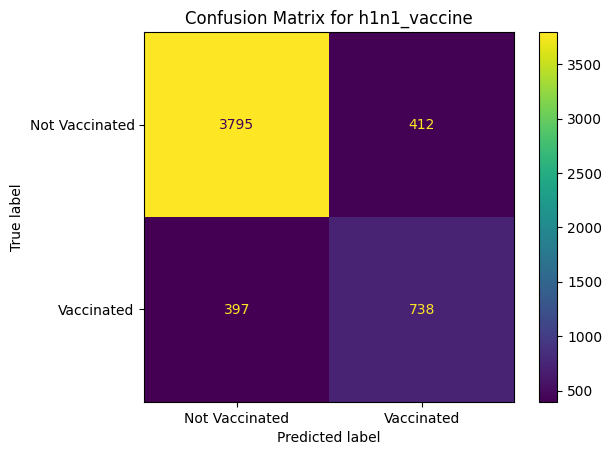

In [11]:
# Matriz de confusión
cm_h1n1 = confusion_matrix(y_test['h1n1_vaccine'], h1n1_predictions)
disp_h1n1 = ConfusionMatrixDisplay(confusion_matrix=cm_h1n1, display_labels=['Not Vaccinated', 'Vaccinated'])
disp_h1n1.plot()
plt.title('Confusion Matrix for h1n1_vaccine')
plt.show()

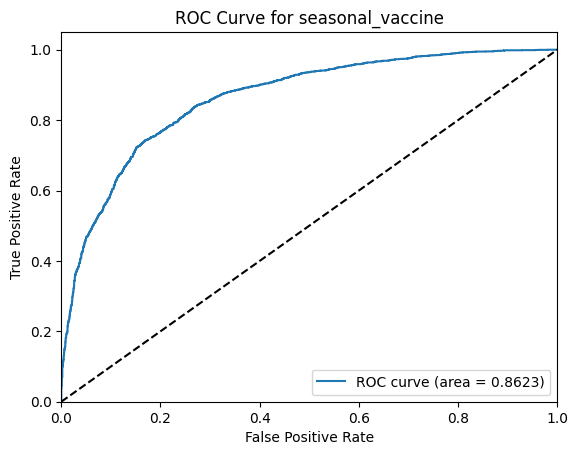

AUROC para Seasonal: 0.8622886702704163


In [12]:
# Predicción y evaluación para seasonal
seasonal_predictions = model_seasonal.predict(X_test)
seasonal_probabilities = model_seasonal.predict_proba(X_test)[:, 1]

# Calculamos la curva ROC y el valor ROC AUC para seasonal_vaccine
fpr, tpr, thresholds = roc_curve(y_test['seasonal_vaccine'], seasonal_probabilities)
roc_auc_seasonal = roc_auc_score(y_test['seasonal_vaccine'], seasonal_probabilities)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc_seasonal)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for seasonal_vaccine')
plt.legend(loc="lower right")
plt.show()
print(f"AUROC para Seasonal: {roc_auc_seasonal}")

In [13]:
# Predicciones binarias para calcular accuracy
seasonal_predictions_binary = (seasonal_probabilities >= 0.5).astype(int)

# Calcular accuracy
accuracy_seasonal = accuracy_score(y_test['seasonal_vaccine'], seasonal_predictions_binary)
print(f"Accuracy for seasonal_vaccine: {accuracy_seasonal:.4f}")

Accuracy for seasonal_vaccine: 0.7829


In [14]:
print("seasonal_vaccine Classification Report:")
print(classification_report(y_test['seasonal_vaccine'], seasonal_predictions))

seasonal_vaccine Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80      2854
           1       0.76      0.77      0.77      2488

    accuracy                           0.78      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.78      0.78      0.78      5342



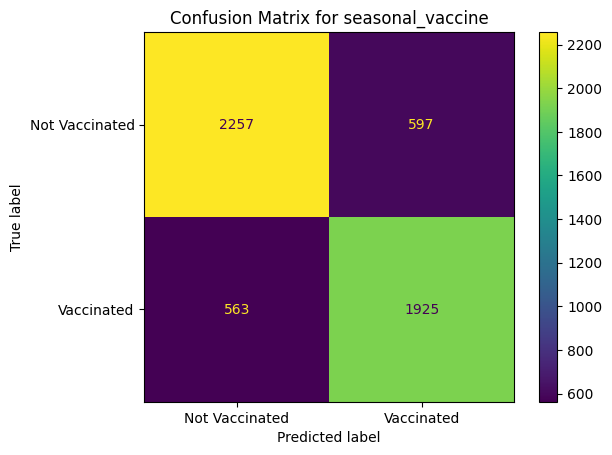

In [15]:
# Matriz de confusión
cm_seasonal = confusion_matrix(y_test['seasonal_vaccine'], seasonal_predictions)
disp_seasonal = ConfusionMatrixDisplay(confusion_matrix=cm_seasonal, display_labels=['Not Vaccinated', 'Vaccinated'])
disp_seasonal.plot()
plt.title('Confusion Matrix for seasonal_vaccine')
plt.show()

In [16]:
# Calcular la media del valor ROC AUC
average_roc_auc = (roc_auc_h1n1 + roc_auc_seasonal) / 2
print("Average ROC AUC Score:", average_roc_auc)

Average ROC AUC Score: 0.8700071911471623


## 4. Guardamos los modelos

Si los modelos entrenados obtienen mejores métricas que los que ya hemos guardado previamente, los sobreescribimos para tener los mejores modelos guardados.

In [17]:
def save_model_if_better(model, current_roc_auc, model_path, metric_path):

    # Cargar la métrica del modelo previo si existe
    if os.path.exists(metric_path):
        with open(metric_path, "r") as f:
            best_roc_auc = float(f.read().strip())
    else:
        best_roc_auc = 0.0
    
    print(f"Current ROC AUC: {current_roc_auc:.4f} | Best ROC AUC: {best_roc_auc:.4f}")

    # Comparar y guardar el modelo si mejora
    if current_roc_auc > best_roc_auc:
        print("El modelo es mejor que el anterior...")
        joblib.dump(model, model_path)  # Guardar el modelo
        with open(metric_path, "w") as f:
            f.write(f"{current_roc_auc:.4f}")  # Guardar la métrica actual
    else:
        print("El modelo no es mejor que el anterior. Saltando el guardado.")

In [18]:
# Guardar el modelo h1n1
model_path_h1n1 = "Modelos/CatBoost_h1n1_best_model.pkl"
metric_path_h1n1 = "Modelos/CatBoost_best_roc_auc_h1n1.txt"
save_model_if_better(model_h1n1, roc_auc_h1n1, model_path_h1n1, metric_path_h1n1)

# Guardar el modelo seasonal
model_path_seasonal = "Modelos/CatBoost_seasonal_best_model.pkl"
metric_path_seasonal = "Modelos/CatBoost_best_roc_auc_seasonal.txt"
save_model_if_better(model_seasonal, roc_auc_seasonal, model_path_seasonal, metric_path_seasonal)

Current ROC AUC: 0.8777 | Best ROC AUC: 0.8666
El modelo es mejor que el anterior...
Current ROC AUC: 0.8623 | Best ROC AUC: 0.8584
El modelo es mejor que el anterior...


## 5. Generación del Archivo de Envío

Finalmente, usamos los modelos optimizados para predecir las probabilidades en el dataset de prueba y generamos el archivo submission.csv.

In [21]:
# Cargar el dataset de prueba preprocesado
test_set_preprocessed = pd.read_csv("../../Data/preprocessed_test_set_features.csv")

# Asegurarse de que respondent_id esté disponible
respondent_ids = test_set_preprocessed['respondent_id']

# Eliminar respondent_id del conjunto de características
X_test_final = test_set_preprocessed.drop(columns=['respondent_id'])

# Predicciones de probabilidad para H1N1
y_proba_h1n1_test = opt_h1n1.best_estimator_.predict_proba(X_test_final)[:, 1]  # Probabilidades de la clase positiva (1)

# Predicciones de probabilidad para vacuna estacional
y_proba_seasonal_test = opt_seasonal.best_estimator_.predict_proba(X_test_final)[:, 1]  # Probabilidades de la clase positiva (1)

# Crear el DataFrame de submission
submission = pd.DataFrame({
    "respondent_id": respondent_ids,
    "h1n1_vaccine": y_proba_h1n1_test,
    "seasonal_vaccine": y_proba_seasonal_test
})

# Guardar el archivo de submission
submission.to_csv("Submissions/CatBoost_submission.csv", index=False)
print("Archivo 'CatBoost_submission.csv' generado correctamente.")

Archivo 'CatBoost_submission.csv' generado correctamente.
